In [1]:
ON_COLAB = True
USE_DRIVE = False

In [2]:
if ON_COLAB:
    # ----- for colab
    from zipfile import ZipFile

    with ZipFile("dataset/images.zip", 'r') as zObject:

        zObject.extractall(
            path="dataset")

In [3]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [4]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        if USE_DRIVE:
            self.root = Path("drive") / "MyDrive" / "Colab Notebooks" / "cv" / "dataset"
        elif ON_COLAB:
            self.root = Path("dataset")
        else:
            self.root = Path("/home/liam/Desktop/magistrale/computervision/progetto/modulo_due/ipcv-assignment-2/dataset")
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [5]:
import random
from torchvision import transforms
from torchvision.transforms import functional as tF

class Random90DegreeRotation:
    """Custom transform for 90-degree rotations with specific probabilities."""
    def __call__(self, img):
        prob = random.random()
        if prob < 0.5:
            return img  # No rotation
        elif prob < 0.75:
            return tF.rotate(img, angle=-90)  # Rotate 90 degrees left
        else:
            return tF.rotate(img, angle=90)  # Rotate 90 degrees right

class OuterRandomCrop:
    """Custom transform to randomly crop the same amount of pixels from each side of the image."""
    def __init__(self, max_pixels_to_crop):
        """
        Args:
            max_pixels_to_crop (int): The maximum number of pixels to subtract from each side of the image.
        """
        self.max_pixels_to_crop = max_pixels_to_crop

    def __call__(self, img):
        # decides whether to apply the crop (75% chance)
        if random.random() < 0.25:
            return img

        # randomly select the number of pixels to crop (between 0 and max_pixels_to_crop)
        pixels_to_crop = random.randint(0, self.max_pixels_to_crop)

        width, height = img.size
        crop_left = pixels_to_crop
        crop_top = pixels_to_crop
        crop_width = width - 2 * pixels_to_crop
        crop_height = height - 2 * pixels_to_crop

        if crop_width <= 0 or crop_height <= 0:
            raise ValueError("The number of pixels to crop is too large for the image dimensions.")

        return tF.crop(img, top=crop_top, left=crop_left, height=crop_height, width=crop_width)


convert_compatible = transforms.Compose([
    transforms.Resize((224, 224)),     # Deterministic resize
    transforms.ToTensor(),             # Format conversion only
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # image net normalization values
])

transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),       # Random horizontal flip
    OuterRandomCrop(20),                 # Custom outer crop
    Random90DegreeRotation(),                    # Custom 90-degree rotation
    transforms.RandomRotation(10),              # Random rotation of ±10 degrees
    transforms.ColorJitter(brightness=0.4),      # Adjust brightness slightly
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = OxfordPetDataset('train', transform=transform_data_augmentation)
val_dataset = OxfordPetDataset('val', transform=convert_compatible)
test_dataset = OxfordPetDataset('test', transform=convert_compatible)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

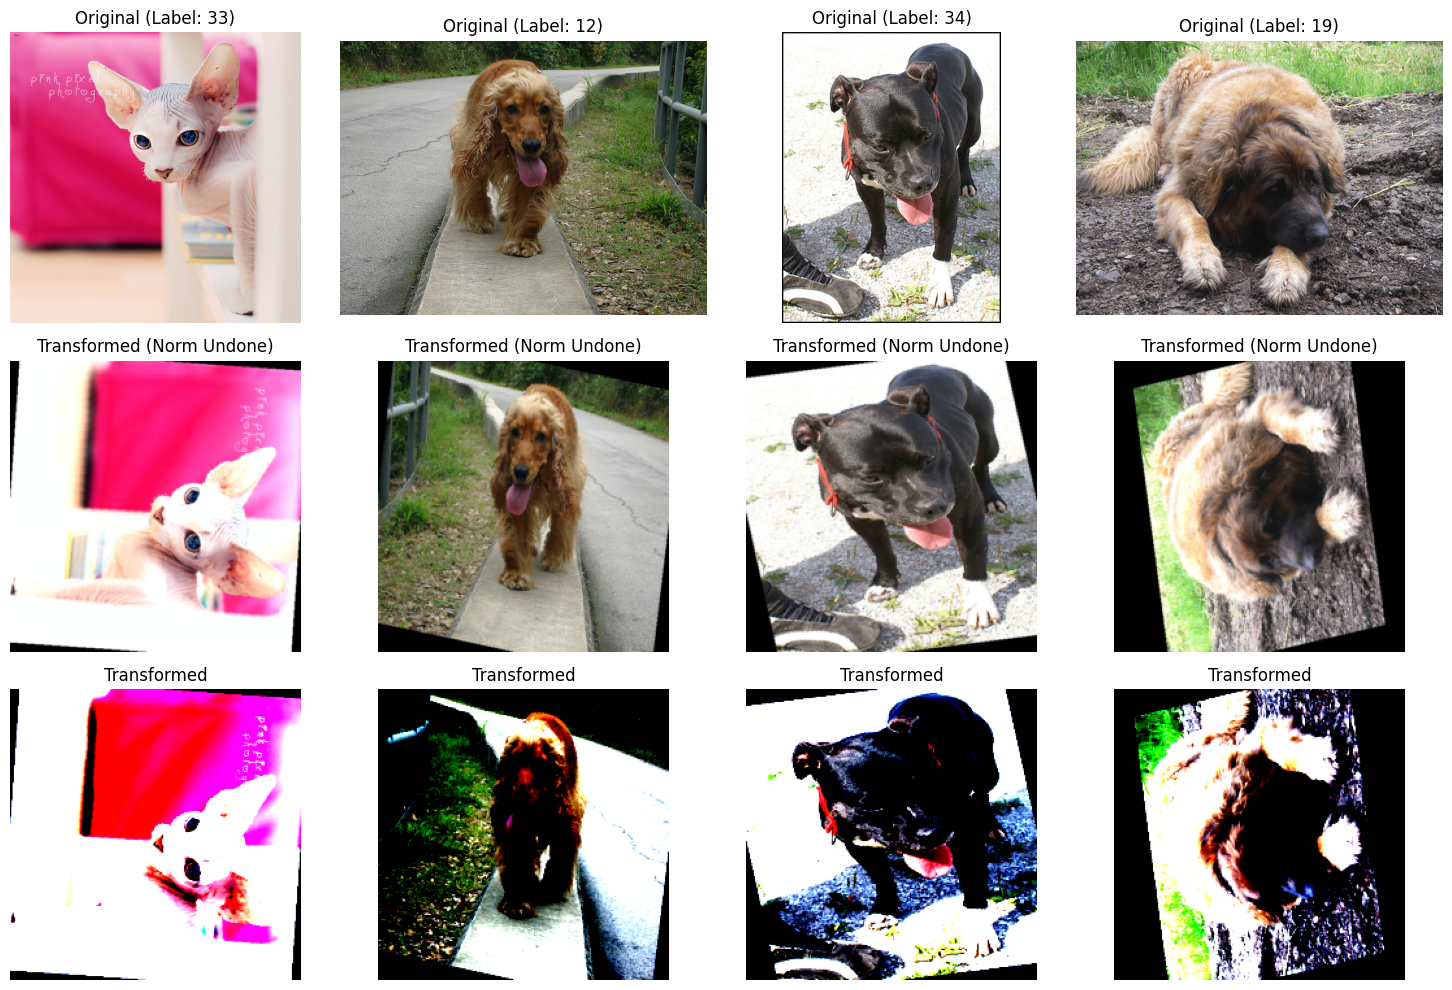

In [8]:
import matplotlib.pyplot as plt
import random

# Function to display images
def display_image_comparison(dataset, num_images=4):
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))  # 3 rows, num_images columns

    for i in range(num_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)

        # Access the raw image without applying the dataset's transform
        img_path = dataset.root / "images" / f"{dataset.names[idx]}.jpg"
        original_img = Image.open(img_path).convert("RGB")  # Load as PIL image
        label = dataset.labels[idx]

        # Apply your transformation
        transformed_with_norm = transform_data_augmentation(original_img)  # Fully transformed with normalization

        # Undo normalization for visualization
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        transformed_with_norm_np = transformed_with_norm.permute(1, 2, 0).numpy()
        transformed_no_norm_np = std * transformed_with_norm_np + mean  # Undo normalization
        transformed_no_norm_np = transformed_no_norm_np.clip(0, 1)

        # Display original image
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f"Original (Label: {label})")
        axes[0, i].axis("off")

        # Display transformed image with normalization undone
        axes[1, i].imshow(transformed_no_norm_np)
        axes[1, i].set_title("Transformed (Norm Undone)")
        axes[1, i].axis("off")

        # Display fully transformed image (with normalization)
        axes[2, i].imshow(transformed_with_norm_np)
        axes[2, i].set_title("Transformed")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display the comparison
display_image_comparison(train_dataset, num_images=4)

In [18]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    show_all_minibatches_loss=False,
    lr_scheduler_fn=None  # Function to calculate the next learning rate
):
    """
    Trains a PyTorch model and evaluates it on a validation set.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function to optimize.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        num_epochs (int): Number of epochs to train the model.
        show_all_minibatches_loss (bool): Can be 'no', 'brief', 'verbose'. Determines how many mini batch losses are printed
        lr_scheduler_fn (callable, optional): Function to adjust the learning rate based on a metric (validation accuracy).

    Returns:
        tuple: A tuple containing:
            - train_losses (list): List of average training losses per epoch.
            - train_accuracies (list): List of training accuracies per epoch.
            - train_class_accuracies (list): List of per-class training accuracies per epoch.
            - val_losses (list): List of validation losses per epoch.
            - val_accuracies (list): List of validation accuracies per epoch.
            - val_class_accuracies (list): List of per-class validation accuracies per epoch.
    """

    train_losses = []
    train_accuracies = []
    train_class_accuracies = []
    val_losses = []
    val_accuracies = []
    val_class_accuracies = []

    # Get number of classes from the model's output layer
    num_classes = model.fc.out_features

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Initialize per-class counters for training
        train_class_correct = torch.zeros(num_classes, dtype=torch.long)
        train_class_total = torch.zeros(num_classes, dtype=torch.long)

        tot_batches = train_loader.__len__()
        for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Zero gradients from previous iteration
            optimizer.zero_grad()

            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            if show_all_minibatches_loss != 'no':
                if show_all_minibatches_loss == 'verbose' or batch_idx in [40, 80]:
                    print(f"Batch {batch_idx + 1}/{tot_batches}: loss = {loss.item():.4f}")

            # Compute gradients
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()

            # Per-class accuracy for training
            for i in range(batch_labels.size(0)):
                label = batch_labels[i]
                train_class_total[label] += 1
                if predicted[i] == label:
                    train_class_correct[label] += 1

        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(train_loader)

        # Calculate per-class accuracies for training
        epoch_train_class_accuracies = []
        for i in range(num_classes):
            if train_class_total[i] > 0:
                class_acc = train_class_correct[i].item() / train_class_total[i].item()
            else:
                class_acc = 0.0  # No samples for this class in training set
            epoch_train_class_accuracies.append(class_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Initialize per-class counters for validation
        val_class_correct = torch.zeros(num_classes, dtype=torch.long)
        val_class_total = torch.zeros(num_classes, dtype=torch.long)

        with torch.no_grad():  # Doesn't compute gradients for validation
            for batch_images, batch_labels in val_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_images)
                loss = criterion(outputs, batch_labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted == batch_labels).sum().item()

                # Per-class accuracy for validation
                for i in range(batch_labels.size(0)):
                    label = batch_labels[i]
                    val_class_total[label] += 1
                    if predicted[i] == label:
                        val_class_correct[label] += 1

        val_accuracy = 100 * correct_val / total_val
        val_loss = running_val_loss / len(val_loader)

        # Calculate per-class accuracies for validation
        epoch_val_class_accuracies = []
        for i in range(num_classes):
            if val_class_total[i] > 0:
                class_acc = val_class_correct[i].item() / val_class_total[i].item()
            else:
                class_acc = 0.0  # No samples for this class in validation set
            epoch_val_class_accuracies.append(class_acc)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_class_accuracies.append(epoch_train_class_accuracies)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_class_accuracies.append(epoch_val_class_accuracies)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Adjust learning rate using the scheduler function
        if lr_scheduler_fn is not None:
            new_lr = lr_scheduler_fn(optimizer.param_groups[0]['lr'], val_accuracies)
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr # we only modify the learning rate in the optimizer we chose

        print('-'*20)

    return train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies, val_class_accuracies



def val_accuracy_scheduler(current_lr, val_accuracies, patience=5, decay_factor=0.1):
    """
    Adjusts the learning rate based on validation accuracy.

    Args:
        current_lr (float): Current learning rate.
        val_accuracies (list): List of validation accuracies from previous epochs.
        patience (int): Number of epochs to wait for improvement before reducing the learning rate.
        decay_factor (float): Factor by which to reduce the learning rate.

    Returns:
        float: New learning rate.
    """
    if len(val_accuracies) > patience:
        recent_accuracies = val_accuracies[-patience:]
        if max(recent_accuracies) <= val_accuracies[-(patience + 1)] + 1:  #1 percentage of tolerance (the increases should be substantial)
            new_lr = current_lr * decay_factor
            print(f"Learning rate adjusted to: {new_lr}")
            return new_lr
    return current_lr

# resnet model

In [20]:
class BasicBlock(nn.Module):
    """A basic residual block for ResNet."""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    """Custom ResNet architecture."""
    def __init__(self, block, layers, num_classes=37):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def resnet18(num_classes=37):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


num_classes = 37
model_resnet = resnet18(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet = model_resnet.to(device)


from torchsummary import summary
summary(model_resnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
        BasicBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
       BasicBlock-14           [-1, 64,

In [21]:
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies, val_class_accuracies = train_model(
    model_resnet, train_loader, val_loader, criterion, optimizer, num_epochs=70, show_all_minibatches_loss='no', lr_scheduler_fn=val_accuracy_scheduler
)

Epoch [1/70], Train Loss: 3.6954, Train Acc: 4.77%, Val Loss: 3.6786, Val Acc: 4.03%
--------------------
Epoch [2/70], Train Loss: 3.4982, Train Acc: 6.05%, Val Loss: 3.5203, Val Acc: 7.47%
--------------------
Epoch [3/70], Train Loss: 3.3806, Train Acc: 8.59%, Val Loss: 3.5161, Val Acc: 7.52%
--------------------
Epoch [4/70], Train Loss: 3.2738, Train Acc: 10.55%, Val Loss: 3.4040, Val Acc: 9.43%
--------------------
Epoch [5/70], Train Loss: 3.2067, Train Acc: 11.69%, Val Loss: 3.3549, Val Acc: 9.54%
--------------------
Epoch [6/70], Train Loss: 3.1460, Train Acc: 12.16%, Val Loss: 3.3799, Val Acc: 8.78%
--------------------
Epoch [7/70], Train Loss: 3.0900, Train Acc: 14.15%, Val Loss: 3.3008, Val Acc: 10.63%
--------------------
Epoch [8/70], Train Loss: 3.0071, Train Acc: 15.10%, Val Loss: 3.2084, Val Acc: 12.27%
--------------------
Epoch [9/70], Train Loss: 2.9209, Train Acc: 17.91%, Val Loss: 3.1780, Val Acc: 13.85%
--------------------
Epoch [10/70], Train Loss: 2.8720, Tr

In [23]:
import os
import pickle



output_dir = "results"

os.makedirs(output_dir, exist_ok=True)

# Save training losses
with open(os.path.join(output_dir, "train_losses.pkl"), "wb") as f:
    pickle.dump(train_losses, f)

with open(os.path.join(output_dir, "train_accuracies.pkl"), "wb") as f:
    pickle.dump(train_accuracies, f)

with open(os.path.join(output_dir, "train_class_accuracies.pkl"), "wb") as f:
    pickle.dump(train_class_accuracies, f)

with open(os.path.join(output_dir, "val_losses.pkl"), "wb") as f:
    pickle.dump(val_losses, f)

with open(os.path.join(output_dir, "val_accuracies.pkl"), "wb") as f:
    pickle.dump(val_accuracies, f)

with open(os.path.join(output_dir, "val_class_accuracies.pkl"), "wb") as f:
    pickle.dump(val_class_accuracies, f)

torch.save(model_resnet, "resnet_18_complete_training_weights")

# Test set accuracy

In [22]:
# Load the saved model weights and map them to the CPU
# model_resnet.load_state_dict(torch.load("resnet_18_complete_training_weights", map_location=torch.device('cpu')))
# model_resnet = model_resnet.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Set the model to evaluation mode
model_resnet.eval()

# Initialize variables to track correct predictions and total samples
correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        # Move data to the same device as the model
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass: get predictions
        outputs = model_resnet(batch_images)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

# Calculate and print the accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 52.93%


In [ ]:

def test_set_accuracy(model, test_loader, print_result=True):
    model.eval()

    # Initialize variables to track correct predictions and total samples
    correct = 0
    total = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for batch_images, batch_labels in test_loader:
            # Move data to the same device as the model
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass: get predictions
            outputs = model(batch_images)
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct counts
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    # Calculate and print the accuracy
    test_accuracy = 100 * correct / total
    if print_result:
        print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_accuracy

In [1]:
import matplotlib.pyplot as plt

def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots training and validation losses and accuracies side by side.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        train_accuracies (list): List of training accuracies per epoch.
        val_accuracies (list): List of validation accuracies per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot losses
    axes[0].plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    axes[0].plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracies
    axes[1].plot(epochs, train_accuracies, label='Training Accuracy', color='blue', marker='o')
    axes[1].plot(epochs, val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [2]:
import pickle

def load_training_data_from_file(suffix):
    """
    Load training losses, validation accuracies, and validation class accuracies from pickle files.

    Args:
        suffix (str): The suffix to append to the base filenames (e.g., '_no_skip', '_final').

    Returns:
        tuple: (train_losses, val_accuracies, val_class_accuracies) if files are found, otherwise (None, None, None).
    """
    # Define the filenames based on the suffix
    train_losses_file = f"train_losses{suffix}.pkl"
    val_losses_file = f"val_losses{suffix}.pkl"
    train_accuracies_file = f"train_accuracies{suffix}.pkl"
    val_accuracies_file = f"val_accuracies{suffix}.pkl"
    train_class_accuracies_file = f"train_class_accuracies{suffix}.pkl"
    val_class_accuracies_file = f"val_class_accuracies{suffix}.pkl"

    try:
        with open(train_losses_file, 'rb') as f:
            train_losses = pickle.load(f)

        with open(val_losses_file, 'rb') as f:
            val_losses = pickle.load(f)
        
        with open(train_accuracies_file, 'rb') as f:
            train_accuracies = pickle.load(f)

        with open(val_accuracies_file, 'rb') as f:
            val_accuracies = pickle.load(f)

        with open(train_class_accuracies_file, 'rb') as f:
            train_class_accuracies = pickle.load(f)

        with open(val_class_accuracies_file, 'rb') as f:
            val_class_accuracies = pickle.load(f)

        print(f"Successfully loaded data with suffix '{suffix}'")
        return train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies, val_class_accuracies

    except FileNotFoundError as e:
        print(f"Error: File not found - {e.filename}. Returning None")
        return None, None, None, None, None, None
    except Exception as e:
        print(f"Error loading data: {e}. Returning None")
        return None, None, None, None, None, None

In [3]:
train_losses, train_accuracies, train_class_accuracies, val_losses, val_accuracies, val_class_accuracies = load_training_data_from_file("")


Successfully loaded data with suffix ''


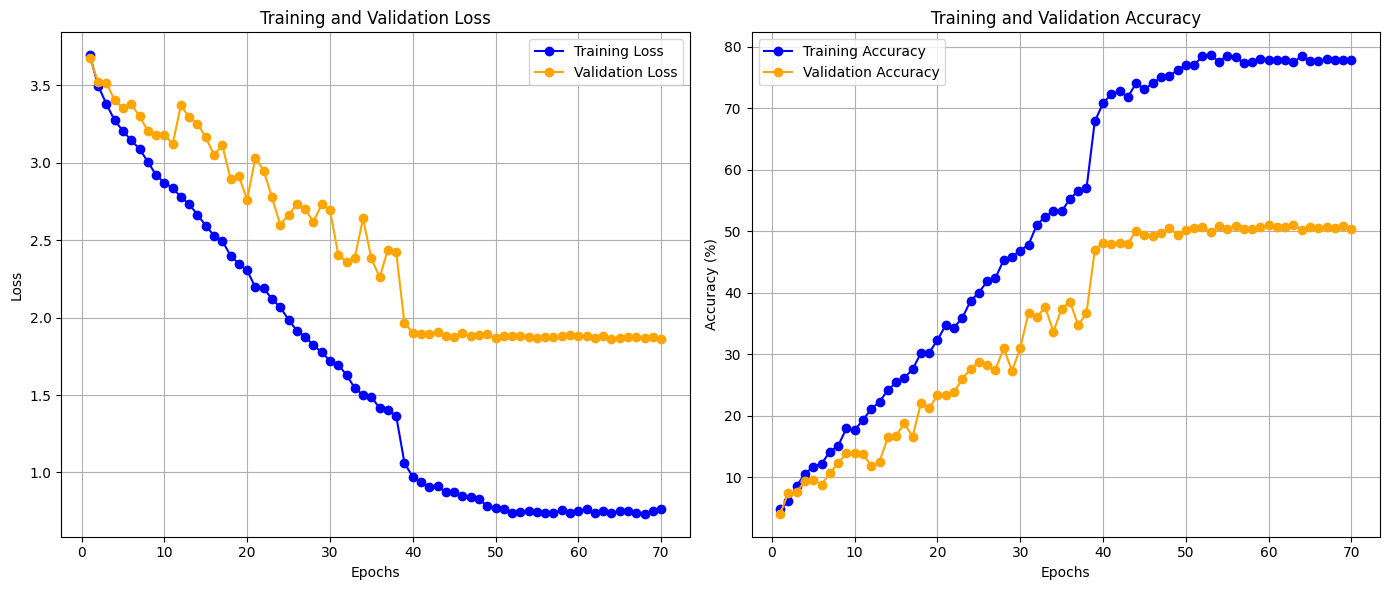

In [5]:
import numpy as np
plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [26]:
val_losses

[3.678550564009568,
 3.520319650913107,
 3.5160833802716485,
 3.4040413313898545,
 3.354900072360861,
 3.3798866765252473,
 3.3007947494243752,
 3.208413537206321,
 3.178026226060144,
 3.1831289550353743,
 3.120694641409249,
 3.3723307128610283,
 3.29334694969243,
 3.25398843247315,
 3.1659969831335135,
 3.0511132684247246,
 3.113363500299125,
 2.89602583441241,
 2.9139474609802507,
 2.7618081014731835,
 3.0328973942789537,
 2.950394533831498,
 2.776317906790766,
 2.601370729249099,
 2.6624549935603965,
 2.7325624268630455,
 2.6993488237775605,
 2.6208076312624176,
 2.731367088597396,
 2.6974801051205604,
 2.4077639590049613,
 2.3602679341003814,
 2.3865972983426063,
 2.6414912394408523,
 2.382926246215557,
 2.2595116311106187,
 2.4395358028083014,
 2.4239510564968505,
 1.9649760897817283,
 1.9037781532468467,
 1.8964178140821129,
 1.895528473730745,
 1.9077843129634857,
 1.878173156031247,
 1.8766404153971836,
 1.9003342646976997,
 1.8796719086581264,
 1.8895605155106248,
 1.894585129

In [28]:
train_losses

[3.678550564009568,
 3.520319650913107,
 3.5160833802716485,
 3.4040413313898545,
 3.354900072360861,
 3.3798866765252473,
 3.3007947494243752,
 3.208413537206321,
 3.178026226060144,
 3.1831289550353743,
 3.120694641409249,
 3.3723307128610283,
 3.29334694969243,
 3.25398843247315,
 3.1659969831335135,
 3.0511132684247246,
 3.113363500299125,
 2.89602583441241,
 2.9139474609802507,
 2.7618081014731835,
 3.0328973942789537,
 2.950394533831498,
 2.776317906790766,
 2.601370729249099,
 2.6624549935603965,
 2.7325624268630455,
 2.6993488237775605,
 2.6208076312624176,
 2.731367088597396,
 2.6974801051205604,
 2.4077639590049613,
 2.3602679341003814,
 2.3865972983426063,
 2.6414912394408523,
 2.382926246215557,
 2.2595116311106187,
 2.4395358028083014,
 2.4239510564968505,
 1.9649760897817283,
 1.9037781532468467,
 1.8964178140821129,
 1.895528473730745,
 1.9077843129634857,
 1.878173156031247,
 1.8766404153971836,
 1.9003342646976997,
 1.8796719086581264,
 1.8895605155106248,
 1.894585129